# Produce potential approximations

This notebook produces approximations of a 1D potential, by default the smoothed Coulomb potential, in terms of
linear combinations of gaussians. The approximation is stored to a pickle file.

The strategy is as follows:
1. Choose half the number $n$ of gaussians, so the total will be $2n$.
2. Produce an initial approximation in terms of a generalized tempered sequence of length $n$ of gaussians. This approximation is produced by optimizing the generating coefficients. The complex cojugate sequence is added to ensure that the potential approximation is real valued.
3. The tempered sequence results in complex width coefficients. These coefficients are subsequently optimized to produce an even better approximation.

Some numerical issues must be dealt with, such as ill-conditioning of the gaussian overlap matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gauss1d import Gauss1D, LCGauss1D, plot_basis
from icecream import ic

# Hack the dark theme for the widget, so that the background is black.
%matplotlib widget
plt.style.use('dark_background')
from vscode_dark_ipywidget_fix.inject_css import inject_css
inject_css()
g = Gauss1D()

In [2]:
# Grid
a = -200
b = 200
ng = 8001
x = np.linspace(a, b, ng)

n = 10
p = 1

# Define external potential
V_fun = lambda x: -1.0/(x**2 + 2)**.5
V = V_fun(x)

name = 'smoothed_coulomb'


In [3]:

df = LCGauss1D(g)


def promote_generalized_tempered(z0):
    z = np.zeros((4,n*2))
    w = (z0[0] + 1j*z0[1]) ** np.arange(1, n+1)
    z[0,:n] = np.log(np.abs(np.real(w)))
    z[1,:n] = np.imag(w)
    z[0,n:] = z[0,:n]
    z[1,n:] = -z[1,:n]
    
    return z

def promote_ab(z0):
    z = np.zeros((4,n*2))
    z0 = z0.reshape((2,n))
    z[0,:n] = z0[0,:]
    z[1,:n] = z0[1,:]
    z[0,n:] = z0[0,:]
    z[1,n:] = -z0[1,:]
    
    return z



def objective(z_vec, promote, verbose=False, print_every=100, p=2):
    z = promote(z_vec)
    df.set_z(z)
    #df.overlap_matrix()
    c = df.projection(x, V)
    c_block = (c[:n] + c[n:].conj())/2 # purify c
    c = np.concatenate([c_block, c_block.conj()])
    
    
    PV = df.eval_grid(x, c)

    if p < np.inf:
        cost = np.sum(np.abs(V - PV)**p * (x[1]-x[0]) )**(1/p) 
    else:
        cost = np.max(np.abs(V - PV))
        
    objective.n_eval += 1
    if verbose:
        if objective.n_eval % print_every == 0:
            print(f'{objective.n_eval} {cost}')
    return cost

objective.n_eval = 0


def test_objective(z_vec, promote, verbose=False, print_every=100, p=2):
    z = promote(z_vec)
    df.set_z(z)
    df.overlap_matrix()
    c = df.projection(x, V)
    S = df.S
    
    # print matrix df.S with 2 decimals
    # ic(df.S)
    test = np.linalg.norm(c[:n]-c[n:].conj())
    #test2 = np.linalg.norm(S[:n,:n] - S[n:,n:].conj()) + np.linalg.norm(S[:n,n:] - S[n:,:n].conj())
    # print('c is not symmetric')
    # print('c block structure error:', test)
    # print('S block structure error: ', test2)
    # print('cond S = ', np.linalg.cond(S))
    #print(np.array2string(np.round(df.S,2)))
    #print(np.array2string(np.round(c,2)))

    return test, np.linalg.cond(S)

c_err = []
S_cond = []
for k in range(1000):
    y = np.random.randn(2)
    promote_generalized_tempered(y)
    c_err0, S_cond0 = test_objective(y, promote_generalized_tempered, verbose=True, print_every=100, p=2)
    c_err.append(c_err0)
    S_cond.append(S_cond0)
    

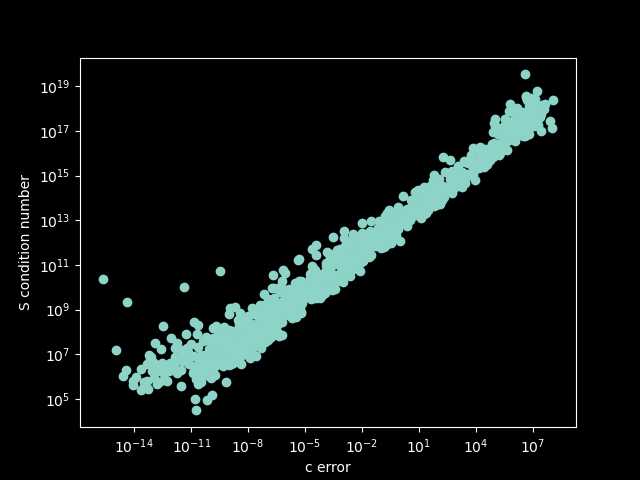

In [4]:
plt.figure()
plt.scatter(c_err, S_cond)
plt.xlabel('c error')
plt.ylabel('S condition number')
plt.xscale('log')
plt.yscale('log')
plt.show()


In [5]:
from scipy.optimize import minimize

def optimize_several_times(n_times, promote, n_var, p=2):

    np.random.seed(10)

    cost_best = np.inf
    y_best = None
    y_list = []
    for k in range(n_times):
        y = np.random.randn(n_var)
        objective.n_eval = 0
        fun = lambda z: objective(z, promote, p=p)
        res = minimize(fun, y, method='Powell', options={'maxiter': 1000}, tol=1e-7)
        #print(res)
        #print(df.z)
        ic(res.fun, res.x)
        if res.fun < cost_best:
            ic('New best!')
            cost_best = res.fun
            y_best = res.x
        y_list.append(res.x)

    return y_best, y_list

y_best, y_list = optimize_several_times(40, promote_generalized_tempered, 2, p=p)

ic| res.fun: 0.43563734388019637
    res.x: array([-0.04765218, -0.41978157])
ic| 'New best!'
ic| res.fun: 0.18361782836594626
    res.x: array([ 3.60673112e-01, -1.89427031e-06])
ic| 'New best!'
ic| res.fun: 0.3586788640171577
    res.x: array([0.17207316, 0.38345984])
ic| res.fun: 0.19132119452113178
    res.x: array([-3.84761280e-01,  4.01474082e-05])
ic| res.fun: 0.14321643089118713
    res.x: array([ 0.41608058, -0.04320745])
ic| 'New best!'
ic| res.fun: 0.3843074475081362
    res.x: array([-0.13529236, -0.38704777])
ic| res.fun: 0.3586788615755583
    res.x: array([-0.17207262,  0.38345991])
ic| res.fun: 0.35867886051689646
    res.x: array([-0.17207238,  0.38345993])
ic| res.fun: 0.14321642994823647
    res.x: array([0.41608091, 0.04320762])
ic| 'New best!'
ic| res.fun: 0.3675463964465795
    res.x: array([-0.14677039, -0.3949772 ])
ic| res.fun: 0.14321643403761142
    res.x: array([0.4160797 , 0.04320659])
ic| res.fun: 0.3512929019248423
    res.x: array([ 0.27368687, -0.316241

/Users/simenkva/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


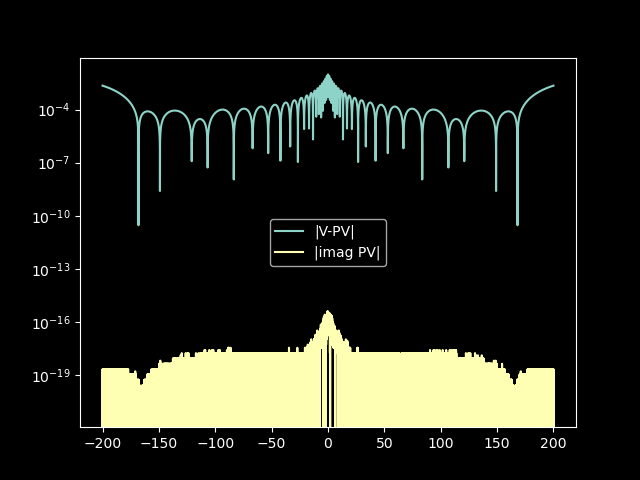

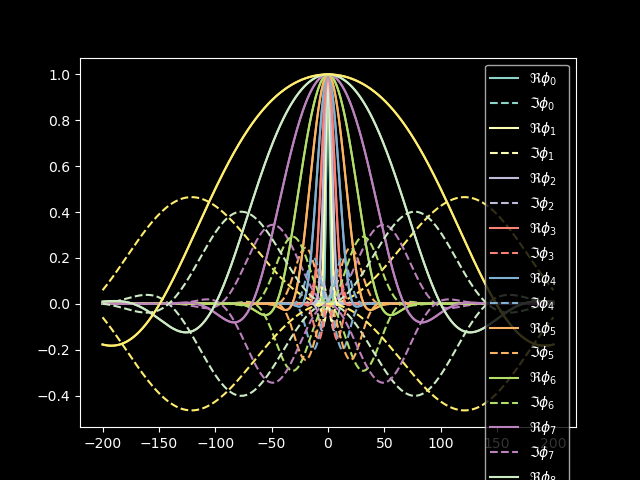

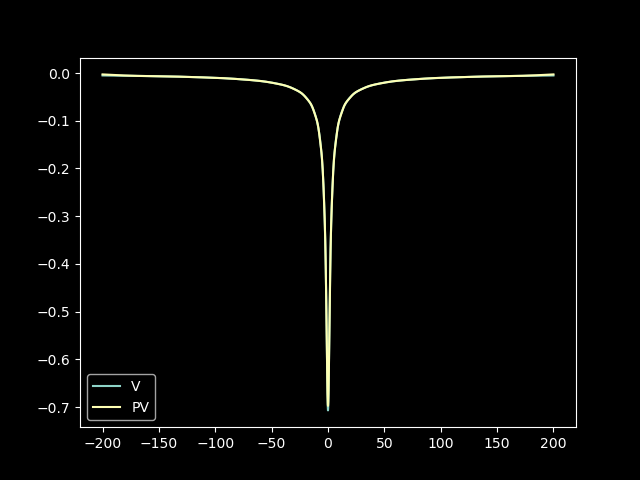

In [6]:
def plot_potential_approx(z_pot):
    df.set_z(z_pot)
    c = df.projection(x, V)
    c_block = (c[:n] + c[n:].conj())/2 # purify c
    c = np.concatenate([c_block, c_block.conj()])
    PV = df.eval_grid(x, c)
    plt.figure()
    plt.plot(x, V, label='V')   
    plt.plot(x, PV, label='PV')
    plt.legend()
    plt.figure()
    plt.semilogy(x, np.abs(V - PV), label='|V-PV|')
    plt.semilogy(x, np.abs(PV.imag), label='|imag PV|')
    plt.legend()
    plt.show()

plot_potential_approx(promote_generalized_tempered(y_best))

plot_basis(df.z, x, g)



In [7]:

objective.n_eval = 0
fun = lambda z: objective(z, promote_ab)
z_best = promote_generalized_tempered(y_best)
y = z_best[:2,:n].flatten()

In [8]:
objective.n_eval = 0
fun = lambda y: objective(y, promote_ab, verbose=True, print_every=100, p=p)
res = minimize(fun, y, method='Powell', options={'maxiter': 1000}, tol=1e-7)
y_best2 = res.x
print(res.x, res.fun)


100 0.07758284376862679
200 0.07654473470720832
300 0.07621120897487986
400 0.10086706997985098
500 0.07455560410103793
600 0.06723175987490057
700 0.066130286230709
800 0.06210579107136401
900 0.06192165953238354
1000 0.06159699671000114
1100 0.06119551843358002
1200 0.06047683179274539
1300 0.06038005858578083
1400 0.0629199784629878
1500 0.0973421931488403
1600 0.059462917127858506
1700 0.07102628425636948
1800 0.05935349250220104
1900 0.059306032517733386
2000 0.05923781605731829
2100 0.062144886115218664
2200 0.05877159418204639
2300 0.058769802527144394
2400 0.1072898422591648
2500 0.05867640177902246
2600 0.05708858107647369
2700 0.056904605881480844
2800 0.05674720798424439
2900 0.05676175854675064
3000 0.056715175984689226
3100 0.1185982952778192
3200 0.0869294342702222
3300 0.05636273097024257
3400 0.056327417961435665
3500 0.05616138998370648
3600 0.05616180689290101
3700 0.0561555541914483
3800 0.16065392395568492
3900 0.05601132824440015
4000 0.05594820167876979
4100 0.055

In [9]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.051639182443719574
       x: [ 6.149e-01 -6.203e-01 ... -4.213e-04 -1.775e-04]
     nit: 35
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  4.854e-02 ... -4.081e-06 -2.137e-06]
           [ 0.000e+00  0.000e+00 ...  0.000e+00 -1.293e-07]]
    nfev: 29420

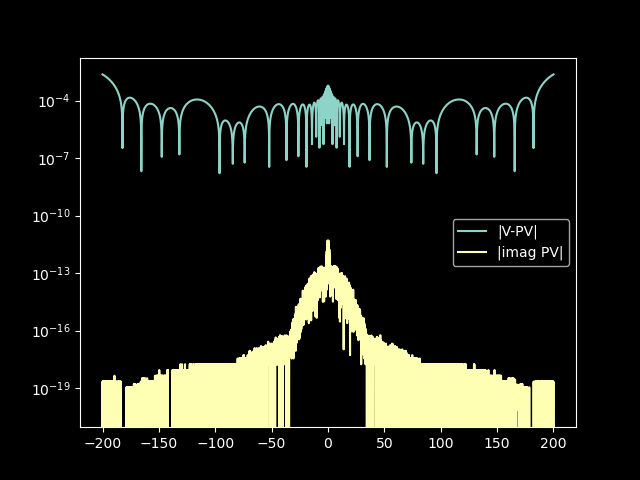

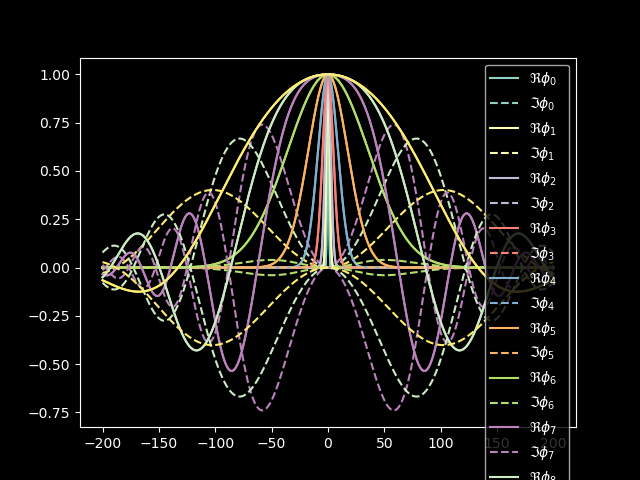

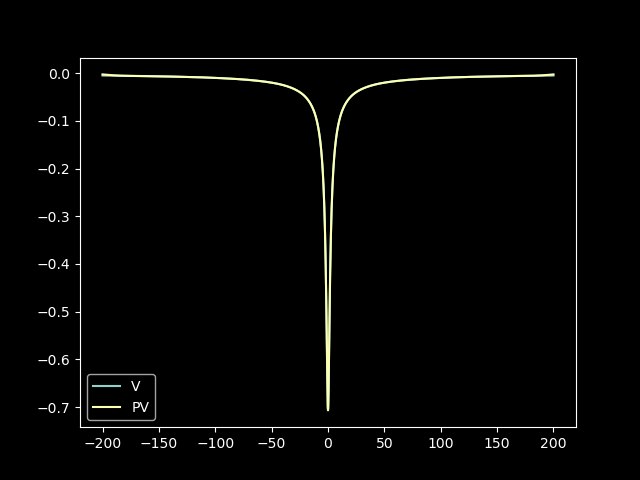

In [10]:
plot_potential_approx(promote_ab(res.x))
# c = df.projection(x, V)
# PV = df.eval_grid(x, c)
# plt.figure()
# plt.plot(x, V, label='V')   
# plt.plot(x, PV, label='PV')
# plt.legend()
# plt.figure()
# plt.semilogy(x, np.abs(V - PV), label='|V-PV|')
# plt.semilogy(x, np.abs(PV.imag), label='|imag PV|')
# plt.legend()
# plt.show()

plot_basis(df.z, x, g)

In [11]:
z_pot = promote_ab(res.x)
df.set_z(z_pot)
c_pot = df.projection(x, V)
c_pot = (c_pot[:n] + c_pot[n:].conj())/2 # purify c
c_pot = np.concatenate([c_pot, c_pot.conj()])
df.set_potential(c_pot, z_pot)
z_diag = np.zeros((4,25))
z_diag[0,:] = np.linspace(-6, 6, 25)
df.set_z(z_diag)
df.set_regularization(lambda_P=1e-3, type_P='tikhonov')
df.overlap_matrix()


In [12]:
from scipy.linalg import eigh
df.hamiltonian_matrix()
S, H = df.S, df.H
e, v = eigh(H, S)
print(e)

[-5.00000020e-01 -1.33828610e-01 -5.88565578e-02 -3.27390542e-02
 -2.07415275e-02 -1.15795891e-02  7.96830540e-03  5.12425085e-02
  1.37599838e-01  2.99134245e-01  5.88679186e-01  1.09272272e+00
  1.95322408e+00  3.40440509e+00  5.83297360e+00  9.87747497e+00
  1.65942711e+01  2.77368947e+01  4.62324329e+01  7.70121959e+01
  1.28514543e+02  2.15576550e+02  3.65613131e+02  6.34513442e+02
  1.16599697e+03]


In [13]:
lcg_state = {'c': c_pot, 'z': z_pot, 'name': name, 'E0': e[0]}

# save
import pickle
with open(f'lcg_{lcg_state["name"]}_ngauss_{len(c_pot)}_p_{p}.pkl', 'wb') as f:
    pickle.dump(lcg_state, f)

